# Linear Regression Models
This notebook fits linear regression models to the joined energy and weather data from Spain, finds the best "alpha" $\alpha$ parameters, and checks the features with the largest coefficients to infer "feature importance". The results are summarized below.

Variable naming convention
- 0 - training/CV set
- 1 - "held-out" test set

The target variables are:
1. `generation solar` ⬅️ expected predictors: cloud, rain, humidity, temp (non time-series)
2. `generation wind onshore` ⬅️ expected predictors: wind (non time-series)

**Models to fit**
1. Linear Regression (OLS)
2. Forward Stepwise Selection (OLS)
3. Ridge Regression
4. Lasso Regression

**Metrics per model**
- Best cross-validated parameter using the 1SE rule: ...
- Training MSE: ...
- Test MSE: ...
- Features with largest coefficients:

In [1]:
# Import libraries
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import project functions
import sys
sys.path.append('../')
from functions import split_by_date

In [2]:
# Output options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#import warnings
#warnings.filterwarnings('ignore')

## Data Preparation
- Source dataset
- Explore shape, and data types
    - n = 35k (four years of hourly data)
    - columns = 105
        - energy: y = 2, other = 18
        - weather (X): 17 x 5 cities = 85
    - data types: all float64 except weather_* (OHE) as 0/1 int64
- Data cleaning:
    - Check missing, duplicates (ID) ⬅️ done in [ML_Project.ipynb](../ML_Project.ipynb)
    - Drop non-predictive features ➡️ drop other energy variables

In [3]:
# Read the joined energy + weather dataset
df = pd.read_csv('../Data/df_final.csv',index_col='time')

In [4]:
# Explore dataset basic info
df.shape #(35064, 105)
df.info(verbose=True, show_counts=True) #>100 rows

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 105 columns):
 #    Column                                       Non-Null Count  Dtype  
---   ------                                       --------------  -----  
 0    generation biomass                           35064 non-null  float64
 1    generation fossil brown coal/lignite         35064 non-null  float64
 2    generation fossil gas                        35064 non-null  float64
 3    generation fossil hard coal                  35064 non-null  float64
 4    generation fossil oil                        35064 non-null  float64
 5    generation hydro pumped storage consumption  35064 non-null  float64
 6    generation hydro run-of-river and poundage   35064 non-null  float64
 7    generation hydro water reservoir             35064 non-null  float64
 8    generation nuclear                           35064 non-null  float64
 9    generation other    

In [5]:
# Quick data cleaning sanity check
df.isnull().sum().sum() # 0 -> missing data
df.index.duplicated().any() # False -> no duplicated indices

False

In [6]:
# Drop non-y energy consumption and generation data (contiguous columns)
drop_cols = list(df.columns[0:11]) + list(df.columns[12:20])
df2 = df.drop(columns=drop_cols)
df2.shape #(35064, 86)

(35064, 86)

## Data Exploration

- Check y = `generation solar`
    - distribution, outliers? ➡️ heavily skewed
    - Cor(y, X) (vs. pair plots) ➡️ moderate correlations with `temp*` (+) and `humidity*` (-)  
- Check X types (num/cat)
	- distrbutions, outliers ➡️ drop `snow_3h*` columns with only zeros, rows with outliers (data error?)
    - Cor(Xi, Xj) ➡️  colinearity ➡️  drop `temp_min*`, `temp_max*`

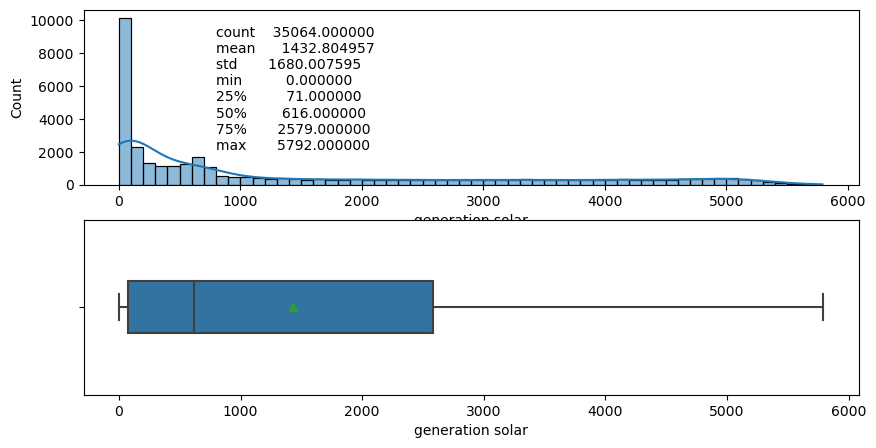

In [7]:
# Check y distribution
y_var = 'generation solar'

# Subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 5))  # 2 rows, 1 column
sns.histplot(data=df2, x=y_var, kde=True, binwidth=100, ax=axes[0])
sns.boxplot(data=df2, x=y_var, width=0.3, showmeans=True, ax=axes[1])

#Annotate
describe_text = df2[y_var].describe().to_string()
plt.text(800, -0.9, describe_text, fontsize=10)

# Adjust layout, show plots
#plt.tight_layout()
plt.show()

In [8]:
#Check Cor(y, X)
s_y_corr = df2.corr()[y_var]
s_y_corr[abs(s_y_corr) > 0.35]

generation solar      1.000000
temp_Barcelona        0.386551
temp_min_Barcelona    0.388822
temp_max_Barcelona    0.372580
humidity_Barcelona   -0.413147
temp_Bilbao           0.398677
temp_min_Bilbao       0.394520
temp_max_Bilbao       0.386096
humidity_Bilbao      -0.364686
temp_Madrid           0.368365
temp_max_Madrid       0.385191
humidity_Madrid      -0.384432
temp_Seville          0.415748
temp_min_Seville      0.408562
temp_max_Seville      0.371631
humidity_Seville     -0.454923
temp_Valencia         0.456559
temp_min_Valencia     0.459349
temp_max_Valencia     0.439888
humidity_Valencia    -0.504773
Name: generation solar, dtype: float64

In [9]:
# X features EDA/viz

#Temp
cols = [col for col in df2.columns if 'temp' in col]
df2[cols].describe()

#Humidity
cols = [col for col in df2.columns if 'humidity' in col]
df2[cols].describe()

#Pressure
cols = [col for col in df2.columns if 'pressure' in col]
df2[cols].describe()
# Drop 2015-02-20 to 2015-02-22
df3 = df2[df2['pressure_Barcelona'] <= 2000]

#Wind
cols = [col for col in df3.columns if 'wind' in col]
df3[cols].describe()

#Rain
cols = [col for col in df3.columns if 'rain' in col]
df3[cols].describe()

#Snow
cols = [col for col in df3.columns if 'snow' in col]
df3[cols].describe()
# Drop "always zero" columns
df4 = df3.drop(columns=['snow_3h_Barcelona', 'snow_3h_Seville'])

#Clouds
cols = [col for col in df4.columns if 'clouds_all' in col]
df4[cols].describe()

,clouds_all_Barcelona,clouds_all_Bilbao,clouds_all_Madrid,clouds_all_Seville,clouds_all_Valencia
count,35019.000000,35019.000000,35019.000000,35019.000000,35019.000000
mean,22.705360,43.377795,20.646478,14.156915,20.741826
std,27.315465,33.717814,29.652076,26.167952,25.602586
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,0.000000,0.000000,0.000000
50%,20.000000,40.000000,0.000000,0.000000,20.000000
75%,36.000000,75.000000,40.000000,20.000000,20.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000


In [10]:
#Check Cor(Xi, Xj)
df4.drop(columns=y_var).corr()
#Drop temp_min, temp_max for now (highly correlated with that city's temp)
cols = [col for col in df3.columns if 'temp_min' in col or 'temp_max' in col]
df5 = df4.drop(columns=cols)
df5.shape #(35019, 74)

(35019, 74)

## Data Pre-processing

- (Extract (+): combine/interact/cross < Drew: context-dependent)
- Split data:
    - y label, X features
    - train/validate // test
- Transform:
	- categorical X ➡️ one-hot-encoding ⬅️ done in [ML_Project.ipynb](../ML_Project.ipynb)
    - numerical X ➡️ standardize (good for Ridge/Lasso, NA for OLS) ➡️ part of modeling pipeline

In [11]:
# Split dataset by y label and X features
X = df5.drop(columns=y_var) #DataFrame (35019, 73)
y = df5[y_var] #Series (35019,)

In [12]:
# Split by train/validate and test
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X0, X1 = split_by_date(X, train_end_date)
y0, y1 = split_by_date(y, train_end_date)

In [13]:
# Setup cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## Linear Regression (OLS)
- Baseline regression: y-hat = y-mean
- Initial LR
	- Residual plots, y-hat vs. y > CHECKS
    - Coeffs (feature importance) vs. feature
	- (Stats: SE, t-stat, p-value)
- Cross-validated LR [Lab 6]

In [14]:
# Baseline "zero-rule" prediction
y_pred_baseline = [y0.mean()] * len(y1)
rmse_baseline = root_mean_squared_error(y1, y_pred_baseline)
r2_baseline = r2_score(y1, y_pred_baseline)
print (f'Baseline RMSE is: {rmse_baseline}')
print (f'Baseline R2 is: {r2_baseline}')

Baseline RMSE is: 1660.0202893011854
Baseline R2 is: -0.0023513335365403787


In [19]:
# Initial Linear Regression (OLS) attempt

# OLS pipeline
ols_model = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# Fit and predict
ols_model.fit(X0, y0)
y1_pred_ols = ols_model.predict(X1)

# Evaluate fit
y0_pred_ols = ols_model.predict(X0)
rmse0_ols = root_mean_squared_error(y0, y0_pred_ols)
r20_ols = r2_score(y0, y0_pred_ols)
print (f'OLS RMSE-train is: {rmse0_ols}')
print (f'OLS R2-train is: {r20_ols}')

# Evaluate accuracy
rmse1_ols = root_mean_squared_error(y1, y1_pred_ols)
r21_ols = r2_score(y1, y1_pred_ols)
print (f'OLS RMSE-test is: {rmse1_ols}')
print (f'OLS R2-test is: {r21_ols}')

OLS RMSE-train is: 1233.392839549666
OLS R2-train is: 0.46562619290539364
OLS RMSE-test is: 1300.6934709420043
OLS R2-test is: 0.38462039223708755


Mean of residuals is: 222.27817249638616


<AxesSubplot:xlabel='y1_pred_ols', ylabel='y1_residual'>

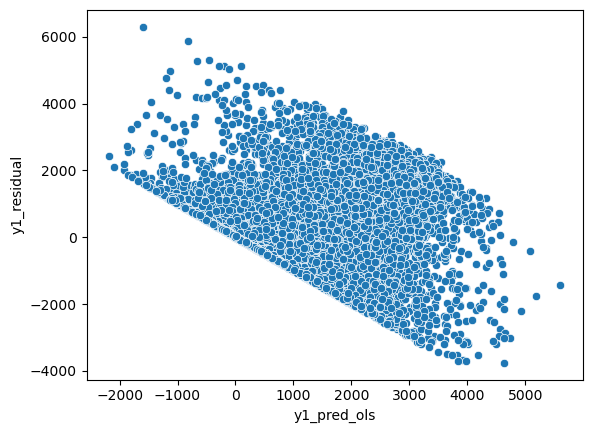

In [37]:
# Residual plot for test data
df_ols_y1 = pd.DataFrame({'y1_true': y1, 'y1_pred_ols': y1_pred_ols})
df_ols_y1['y1_residual'] = df_ols_y1.y1_true - df_ols_y1.y1_pred_ols

# Sanity check residuals mean ~= 0
y1_residual_mean = df_ols_y1['y1_residual'].mean()
print(f'Mean of residuals is: {y1_residual_mean}')

# Plot
sns.scatterplot(data=df_ols_y1, x='y1_pred_ols', y='y1_residual')

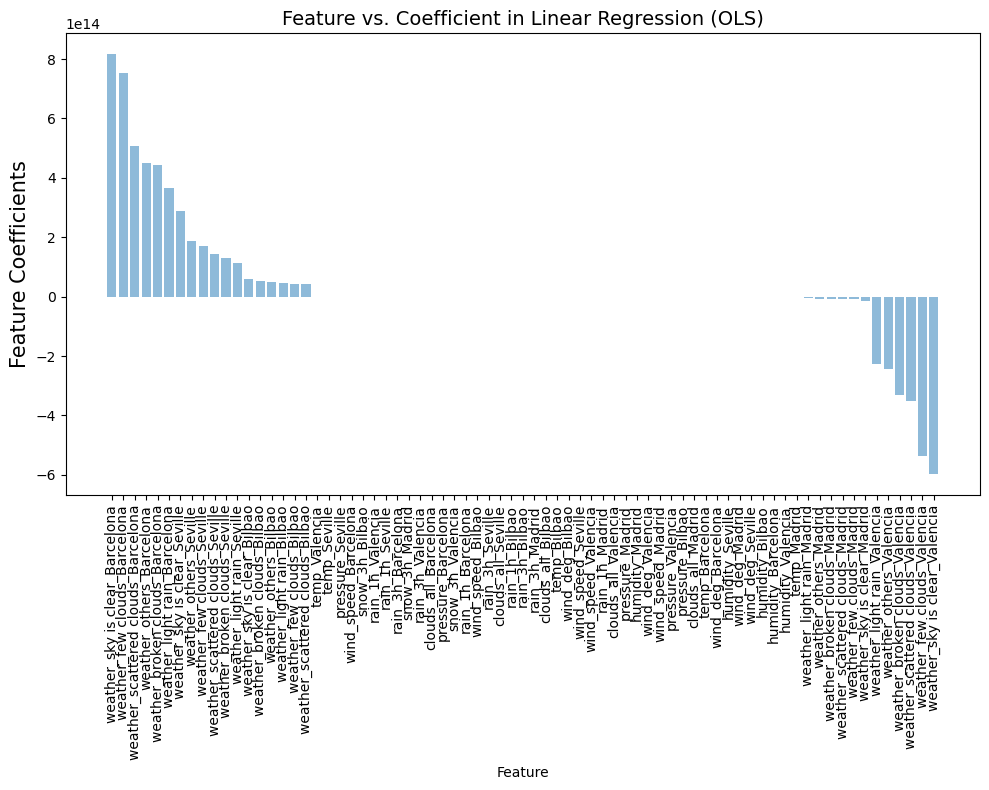

In [40]:
# Check coefficient sizes as measure of "feature importance"

# Get feature names
feature_names = X.columns

# Get feature coefficients
ols_coeff = ols_model[1].coef_
ols_coeff
sorted_indices = np.argsort(ols_coeff)[::-1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title('Feature vs. Coefficient in Linear Regression (OLS)', fontsize=14)
plt.bar(range(len(ols_coeff)), ols_coeff[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(ols_coeff)), feature_names[sorted_indices], rotation=90)
plt.ylabel('Feature Coefficients', fontsize=15)
plt.xlabel('Feature', fontsize=10)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

In [41]:
# Temp code testing cell!
ols_coeff

array([-8.19821293e+01,  2.38973993e+01, -2.84210697e+02,  1.06709082e+02,
       -8.24347938e+01,  1.67239858e+01,  3.57699935e+01,  2.51783544e+01,
        4.44765773e+14,  7.53600317e+14,  3.66170831e+14,  4.50626867e+14,
        5.06313961e+14,  8.15836065e+14, -6.37500000e+00, -7.45625000e+01,
       -2.68414062e+02,  1.67207031e+01, -1.65156250e+01,  4.95312500e+00,
        4.18652344e+00,  7.04687500e+01, -3.16406250e+00,  5.41525690e+13,
        4.35691433e+13,  4.71837099e+13,  5.00221236e+13,  4.29641928e+13,
        5.78796323e+13, -4.59125000e+02, -3.93476562e+01, -4.24687500e+01,
       -4.60566406e+01, -9.97812500e+01, -2.61796875e+01, -2.09570312e+00,
        3.05859375e+01, -7.99609375e+01, -7.40043109e+12, -8.46194741e+12,
       -5.31118835e+12, -7.02108386e+12, -7.43426342e+12, -1.31036782e+13,
        4.65750000e+02,  3.25941406e+02, -9.58750000e+01, -2.12890625e+01,
       -1.71820801e+02,  3.75000000e+01,  1.64824219e+01,  9.67187500e+00,
        1.30832031e+14,  

## Ridge Regression

In [54]:
## Selecting 20 values of alpha
alphas = np.logspace(-6, 6, 20)

mse_scores_ridge = []
std_errors = []  # To store standard errors for each alpha

# Loop through alpha values
for alpha in alphas:
    model = make_pipeline(
        StandardScaler(),
        Ridge(alpha=alpha)
    )
    scores = cross_val_score(model, X_train, ys_train, cv=kf, scoring='neg_mean_squared_error')
    mse_scores_ridge.append(-1 * np.mean(scores))
    # Standard error calculation for each alpha's MSE across folds
    std_errors.append(np.std(scores) / np.sqrt(len(scores)))

# Use the SE for the alpha that gave the minimum MSE
min_mse = min(mse_scores_ridge)
min_mse_index = mse_scores_ridge.index(min_mse)
min_mse_se = std_errors[min_mse_index]
# print("min_mse_se", min_mse_se)

# Apply the one-standard-error rule
within_one_std = min_mse + min_mse_se

candidate_alphas = [alphas[i] for i, mse in enumerate(mse_scores_ridge) if mse <= within_one_std]

best_alpha_ridge = max(candidate_alphas)

print("candidate_alphas",candidate_alphas)
print(f"Best alpha using the one-standard-error rule: {best_alpha_ridge}")

candidate_alphas [1e-06, 4.281332398719396e-06, 1.8329807108324375e-05, 7.847599703514606e-05, 0.0003359818286283781, 0.0014384498882876629, 0.00615848211066026, 0.026366508987303555, 0.11288378916846883, 0.4832930238571752, 2.06913808111479, 8.858667904100814, 37.92690190732246]
Best alpha using the one-standard-error rule: 37.92690190732246


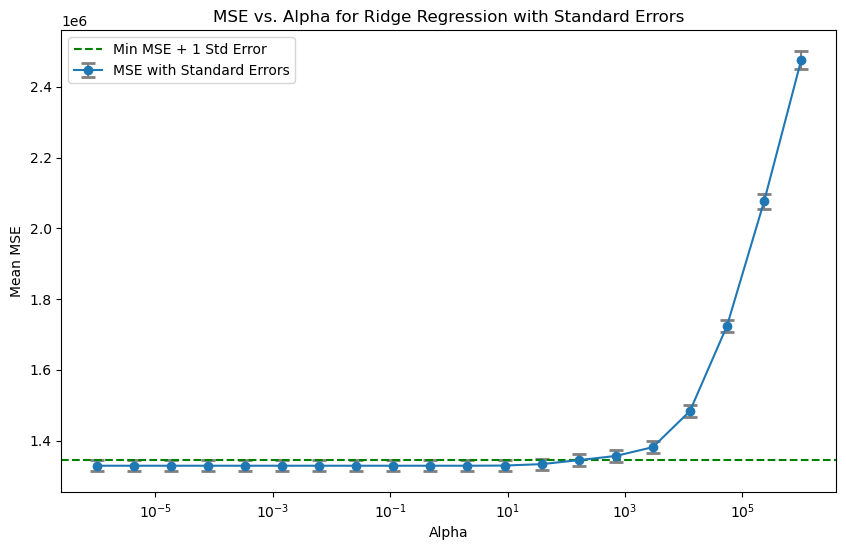

In [55]:
#PLOTTING

plt.figure(figsize=(10, 6))

# Plotting MSE vs Alpha with standard error bars
plt.errorbar(alphas, mse_scores_ridge, yerr=std_errors, fmt='-o', ecolor='gray', capsize=5, capthick=2, label='MSE with Standard Errors')

# Highlighting the best alpha according to the one-standard-error rule with a vertical line
# plt.axvline(x=best_alpha_ridge_one_se, color='red', linestyle='--', label=f'Best Alpha: {best_alpha_ridge}')

# Adding a horizontal line for one standard error above the minimum MSE
plt.axhline(y=within_one_std, color='green', linestyle='--', label='Min MSE + 1 Std Error')

plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.xscale('log')  # Alpha values are on a logarithmic scale
plt.title('MSE vs. Alpha for Ridge Regression with Standard Errors')
plt.legend()

plt.show()

In [56]:
# Ridge model with best alpha
ridge_model = make_pipeline(
    StandardScaler(),
    Ridge(alpha=best_alpha_ridge)
)
ridge_model.fit(X_train, ys_train)
ys_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(ys_test, ys_pred_ridge)

print(f"Test MSE for Ridge: {mse_ridge}")

Test MSE for Ridge: 1704523.0660031326


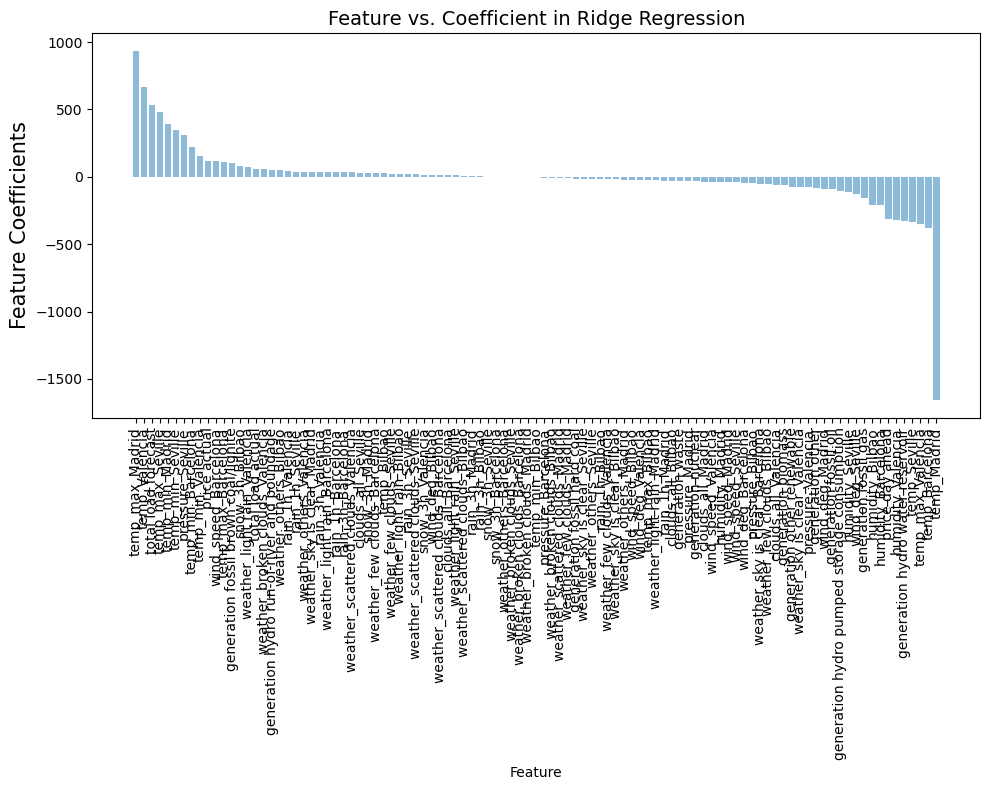

In [57]:
# Check coefficient sizes as measure of "feature importance"

# Get feature names
feature_names = X.columns

# Get feature coefficients
feature_coefficients = ridge_model[1].coef_
sorted_indices = np.argsort(feature_coefficients)[::-1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title('Feature vs. Coefficient in Ridge Regression', fontsize=14)
plt.bar(range(len(feature_coefficients)), feature_coefficients[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(feature_coefficients)), feature_names[sorted_indices], rotation=90)
plt.ylabel('Feature Coefficients', fontsize=15)
plt.xlabel('Feature', fontsize=10)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

## Lasso Regression

In [78]:
## selecting 100 values of alpha
alphas = np.logspace(-4, 4, 100)

alpha_values = []
mse_values = []
best_alpha_lasso = None
lowest_mse_lasso = np.inf

# Loop through alpha values
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, ys_train)
    ys_pred = lasso_model.predict(X_test)
    mse = mean_squared_error(ys_test, ys_pred)
    
    alpha_values.append(alpha)
    mse_values.append(mse)
    
    if mse < lowest_mse_lasso:
        best_alpha_lasso = alpha
        lowest_mse_lasso = mse

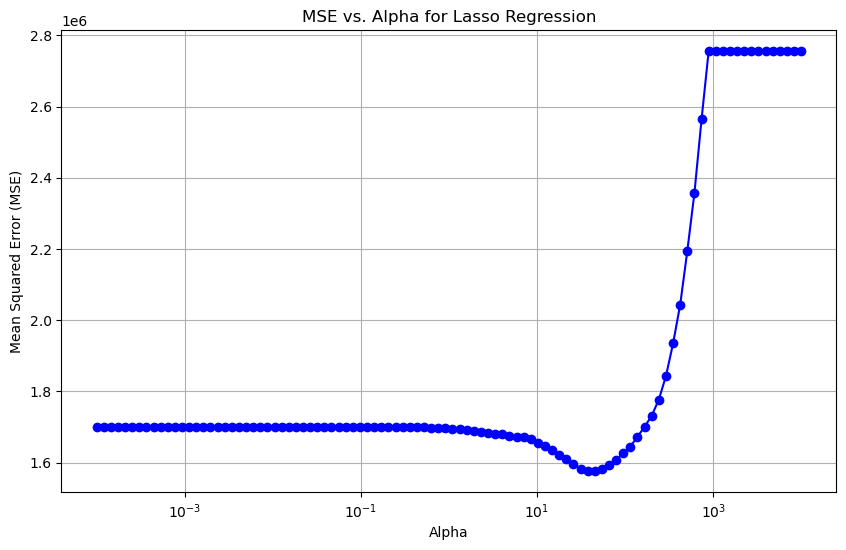

In [79]:
#PLOTTING
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha for Lasso Regression')
plt.grid(True)
plt.show()

In [80]:
print(f"Best Alpha: {best_alpha_lasso}")
print(f"Lowest MSE: {lowest_mse_lasso}")

Best Alpha: 37.649358067924716
Lowest MSE: 1576426.0529618268


In [81]:
# Lasso model with best alpha
best_lasso_model = make_pipeline(
    StandardScaler(),
    Lasso(alpha=best_alpha_lasso)
)
best_lasso_model.fit(X_train, ys_train)
ys_pred_lasso = best_lasso_model.predict(X_test)
mse_lasso = mean_squared_error(ys_test, ys_pred_lasso)

print(f"Test MSE for Ridge: {mse_lasso}")

Test MSE for Ridge: 1576426.0529618268


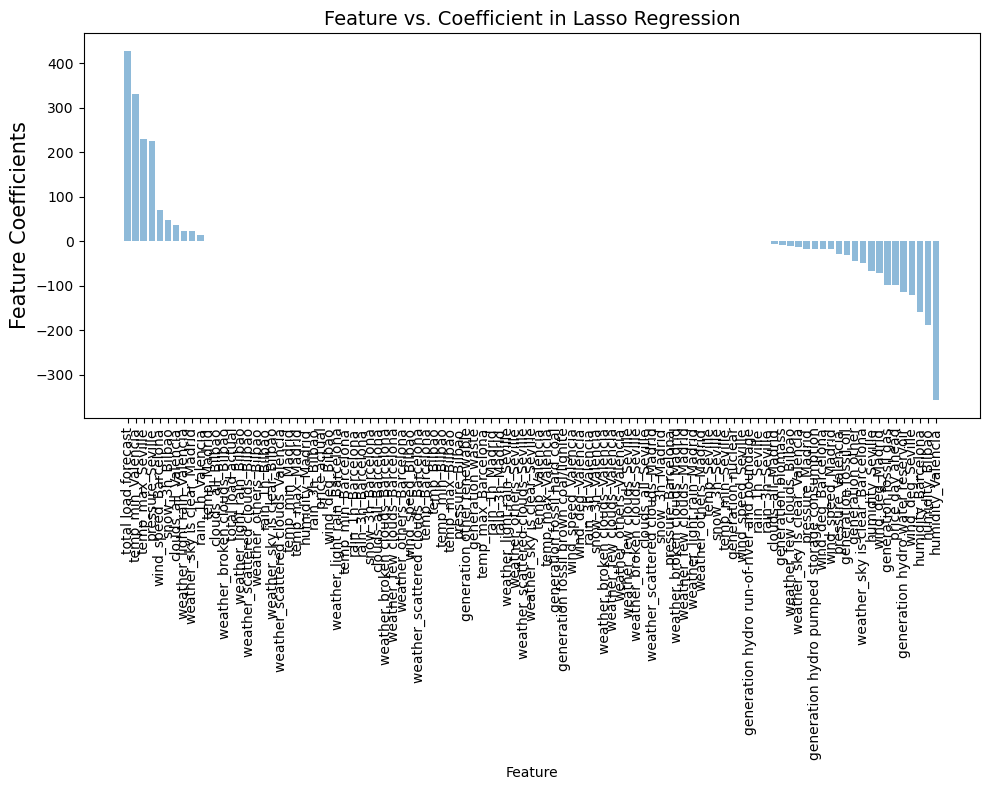

In [82]:
# Check coefficient sizes as measure of "feature importance"

# Get feature names
feature_names = X.columns

# Get feature coefficients
feature_coefficients = best_lasso_model[1].coef_
sorted_indices = np.argsort(feature_coefficients)[::-1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title('Feature vs. Coefficient in Lasso Regression', fontsize=14)
plt.bar(range(len(feature_coefficients)), feature_coefficients[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(feature_coefficients)), feature_names[sorted_indices], rotation=90)
plt.ylabel('Feature Coefficients', fontsize=15)
plt.xlabel('Feature', fontsize=10)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()